In [1]:
import torch
import context
from ccn import Constraint, ConstraintsGroup, Clause, ClausesGroup, Literal, ConstraintsLayer
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
def custom_order():
  return np.array(
    [7,40,23,5,27,28,39,18,19,21,38,22,16,11,20,33,9,30,3,24,4,15,34,31,25,26,13,17,29,37,14,36,12,35,6,0,10,32,2,1,8]
  )

def custom_order2():
  return np.array(
    [7,40,38,23,39,27,11,33,28,5,22,21,24,20,31,16,26,15,9,6,18,34,19,30,25,3,12,2,10,36,8,35,4,32,1,37,29,14,13,17,0]
  )

constraints = ConstraintsGroup('../constraints/full')
print(len(constraints))

clauses = ClausesGroup.from_constraints_group(constraints)
print(len(clauses))

centrality = 'katz'
centrality = custom_order2()
centrality = centrality[::-1]

constraints = clauses.stratify(centrality)
print(len(constraints))

lens = [len(group) for group in constraints]
print(lens)
print(sum(lens))

243
243
17
[3, 5, 7, 9, 17, 12, 14, 16, 15, 18, 21, 20, 22, 36, 21, 14, 28]
278


In [7]:
# measure = clauses.centrality(centrality)
# atoms = list(clauses.atoms())
# atoms.sort(key=lambda x: measure[x])

atoms = custom_order2()
print(atoms)

def revperm(perm):
  result = [-1 for i in range(len(perm))]
  for i, v in enumerate(perm):
    result[v] = i 
  return result 

print(revperm(atoms))

[ 7 40 38 23 39 27 11 33 28  5 22 21 24 20 31 16 26 15  9  6 18 34 19 30
 25  3 12  2 10 36  8 35  4 32  1 37 29 14 13 17  0]
[40, 34, 27, 25, 32, 9, 19, 0, 30, 18, 28, 6, 26, 38, 37, 17, 15, 39, 20, 22, 13, 11, 10, 3, 12, 24, 16, 5, 8, 36, 23, 14, 33, 7, 21, 31, 29, 35, 2, 4, 1]


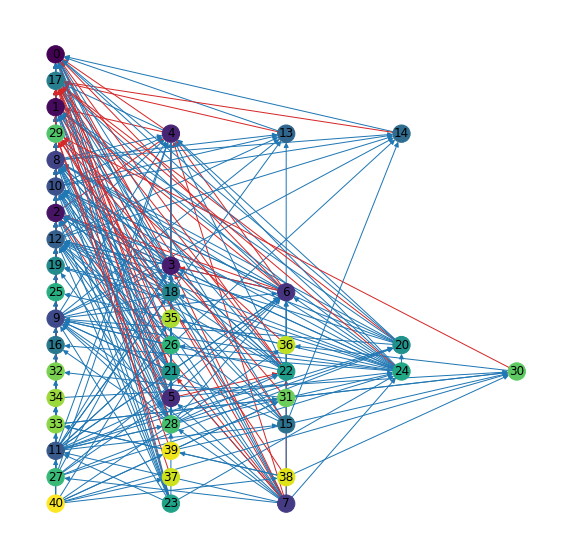

In [6]:
aux = ConstraintsGroup([])
for group in constraints:
  aux = aux + group 

G = aux.graph()

plt.figure(figsize=(10, 10))
ax = plt.subplot()

pos = dict()
for aid, atom in enumerate(aux.atoms().difference(aux.heads())):
  pos[atom] = (aid, -1)
for gid, group in enumerate(constraints):
  for aid, atom in enumerate(group.heads()):
    pos[atom] = (aid, gid)

#centrality = clauses.centrality(centrality)
centrality = {node: node for node in G.nodes()}

edge_color = ['tab:blue' if G[edge[0]][edge[1]]['body'] else 'tab:red' for edge in G.edges()]
node_color = [centrality[node] for node in G.nodes()]

nx.draw(G, with_labels=True, pos=pos, edge_color=edge_color, node_color=node_color)
plt.show()

In [ ]:
layer = ConstraintsLayer(constraints, 41)
preds = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

updated = layer(preds)
assert (updated == preds).all()

fuzzy = 0.2 + preds * 0.8 + torch.rand_like(preds) * 0.1
fuzzy = torch.rand_like(preds) * 0.3
updated = layer(fuzzy, goal=preds)
print(updated)

assert ((updated < 0.5) == (fuzzy < 0.5)).all()

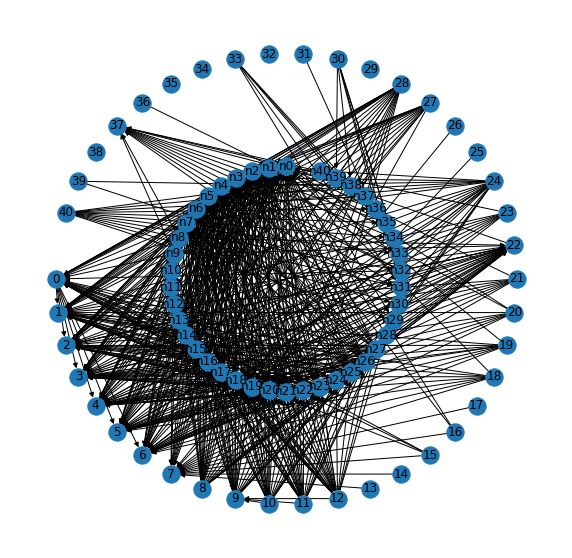

In [5]:
G = aux.duograph()

outer = [str(Literal(atom, True)) for atom in range(42)]
inner = [str(Literal(atom, False)) for atom in range(42)]

plt.figure(figsize=(10, 10))
ax = plt.subplot()
pos = nx.shell_layout(G, [inner, outer])
nx.draw(G, pos=pos, with_labels=True)
plt.show()

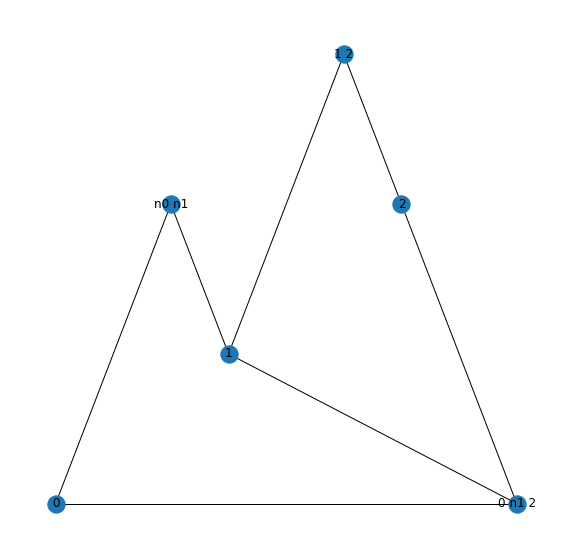

In [6]:
constraints = ConstraintsGroup('../constraints/example')
clauses = ClausesGroup.from_constraints_group(constraints)

plt.figure(figsize=(10, 10))
ax = plt.subplot()
nx.draw_planar(clauses.graph(), with_labels=True)
plt.show()